# Regridding regional mask data onto a 2 x 2 grid
Katie Brennan  
August 2020  
  
### Goal: 
Regrid the NSIDC Arctic regions mask so that it can be applied the LMR reconstructions. Look at regional evolution of Arctic sea ice in different regions. 

### "Conclusions":

#### Land fraction: 

The regridded CCSM4 Last Millennium run data onto a 2x2 degree grid seems to have a slightly different land mask than the land mask that was created by NCL code ('LandSeaMask_2x2.nc'). regridded_data/sftlf_giss_2x2_2.nc seems to be a better land mask file to use. It contains the fraction of land coverage in each grid cell and thus shows a region of <100% coverage around the coastlines from the regridding. Again the coastlines with 100% coverage don't seem to match what's output by the regridded last millennium data.  

#### Cell area: 
Its still unclear whether there is a way to conservatively regrid cellarea files onto a 2x2 grid. There seems to be something wrong with that file that I was originally using (/home/disk/p/mkb22/Documents/si_analysis_kb/regridding/cellareaa_2x2.nc) because the Central Arctic only shows ~40% coverage. There are other versions in Documents/si_analysis_kb/regridding/regridding_data that seem to be potentially better and have been tested in the the regridding folder jupyter notebook. However the total area from before/after regridding doesn't match up as shown in that notebook. But overall we need a cellarea file for this grid and don't seem to have a super trustworthy one. 

#### Moving Forward: 
It would be great to move away from regridding sea ice data. Either staying on the native model grid or moving to the NSIDC grid for sea ice. This would mean that sea ice, tas and potenitally ocean fields may all be on different grids by Kalman Filter DA can handle this and so can LIMs. For LIMs you're working in EOF space. 

In [34]:
import xarray as xr
import sys
import matplotlib.pyplot as plt
#import xesmf as xe

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

In [25]:
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [26]:
import numpy as np 

def load_grid_info(grid_file=None, model=None):
    grid = xr.open_dataset(grid_file)
    n_lat = np.rad2deg(grid.grid_center_lat.values.reshape(tuple(np.flip(grid.grid_dims.T.values,0)))) # Reshape
    n_lon = np.rad2deg(grid.grid_center_lon.values.reshape(tuple(np.flip(grid.grid_dims.T.values,0)))) # Reshape
    grid_imask = grid.grid_imask.values.reshape(tuple(np.flip(grid.grid_dims.T.values,0))) # Reshape

    nj = xr.DataArray(np.arange(0,n_lat.shape[0],1), dims=('nj')) # Make indices
    ni = xr.DataArray(np.arange(0,n_lat.shape[1],1), dims=('ni'))
    lat = xr.DataArray(n_lat, dims=('nj','ni'), coords={'nj':nj, 'ni':ni})
    lon = xr.DataArray(n_lon, dims=('nj','ni'), coords={'nj':nj, 'ni':ni})
    imask = xr.DataArray(grid_imask, dims=('nj','ni'), coords={'nj':nj, 'ni':ni}).astype('bool') # int to bool

    if model=='NSIDC':
        lat_b = cell_bounds_to_corners(gridinfo=grid, varname='grid_corner_lat')
        lon_b = cell_bounds_to_corners(gridinfo=grid, varname='grid_corner_lon')
    else:
        raise ValueError('model not found.')

    # Combine
    return xr.Dataset({'lat':lat, 'lon':lon, 'lat_b':lat_b, 'lon_b':lon_b, 'imask':imask})

def cell_bounds_to_corners(gridinfo=None, varname=None):
    ''' Some models/obs give the four corner lat/lons for each cell. xesmf needs the bounds N+1 grid, this
    converts the former to the later.'''
    
    # Add cell bound coords (lat_b and lon_b)
    n_j = gridinfo.grid_dims.values[1]
    n_i = gridinfo.grid_dims.values[0]
    nj_b = np.arange(0, n_j + 1) # indices of corner of cells
    ni_b = np.arange(0, n_i + 1)

    # Grab all corners as arrays
    dim_out = tuple(np.flip(gridinfo.grid_dims.transpose().values,0))
    ul = gridinfo[varname].isel(grid_corners=0).values.reshape(dim_out)
    ll = gridinfo[varname].isel(grid_corners=1).values.reshape(dim_out)
    lr = gridinfo[varname].isel(grid_corners=2).values.reshape(dim_out)
    ur = gridinfo[varname].isel(grid_corners=3).values.reshape(dim_out)

    # Merge together
    m1 = np.concatenate((ul, ur[:,0][:, None]), axis=1) # add on ur at right
    m2 = np.append(ll[-1,:], lr[-1,0])
    m3 = np.concatenate((m1, m2[:, None].T), axis=0) # add ll and lr to bottom
    ds_out = xr.DataArray(m3, dims=('nj_b', 'ni_b'), coords={'nj_b':nj_b, 'ni_b':ni_b})
    ds_out = xr.ufuncs.rad2deg( ds_out ) # rad to deg
    return ds_out

In [27]:
def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1,colorbar=True,extent=True):
    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    if extent is True: 
        ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1, 1, 1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=plt.cm.RdBu_r, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
    if colorbar is True:
        plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1)

In [28]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

In [29]:
nsidc_grid_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/Observations/'
nsidc_grid_file = 'stereo_gridinfo.nc'
nsidc_grid = load_grid_info(nsidc_grid_dir+nsidc_grid_file, model='NSIDC')

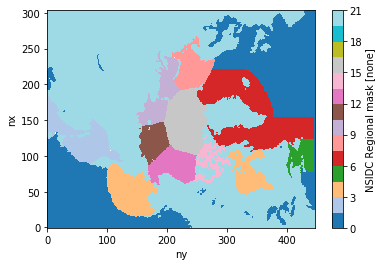

In [30]:
nsidc_mask_dir = '/home/disk/eos8/ed/Greg_proposal/'
nsidc_mask_file = 'sio_mask.nc'

nsidc_regions = xr.open_dataset(nsidc_mask_dir+nsidc_mask_file)

nsidc_regions.rename({'nx':'nj','ny':'ni'})#, inplace=True)
nsidc_regions.mask.plot(levels=len(nsidc_regions.region_names),cmap='tab20')

In [180]:
import cmasher as cmr

cmap = cmr.get_sub_cmap('viridis', 0.2, 0.8)

ModuleNotFoundError: No module named 'cmasher'

In [182]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

VAR1 = np.where((nsidc_regions.mask.values<2),np.nan,nsidc_regions.mask.values)
VAR2 = np.where(VAR1>15,np.nan,VAR1)
VAR3 = np.where(np.isclose(VAR2,5),np.nan,VAR2)
VAR4 = np.where(VAR3>5,VAR3-1,VAR3)
LON = nsidc_regions.lon.values
LAT = nsidc_regions.lat.values

levels=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [221]:
plt.rcParams['figure.dpi']=300

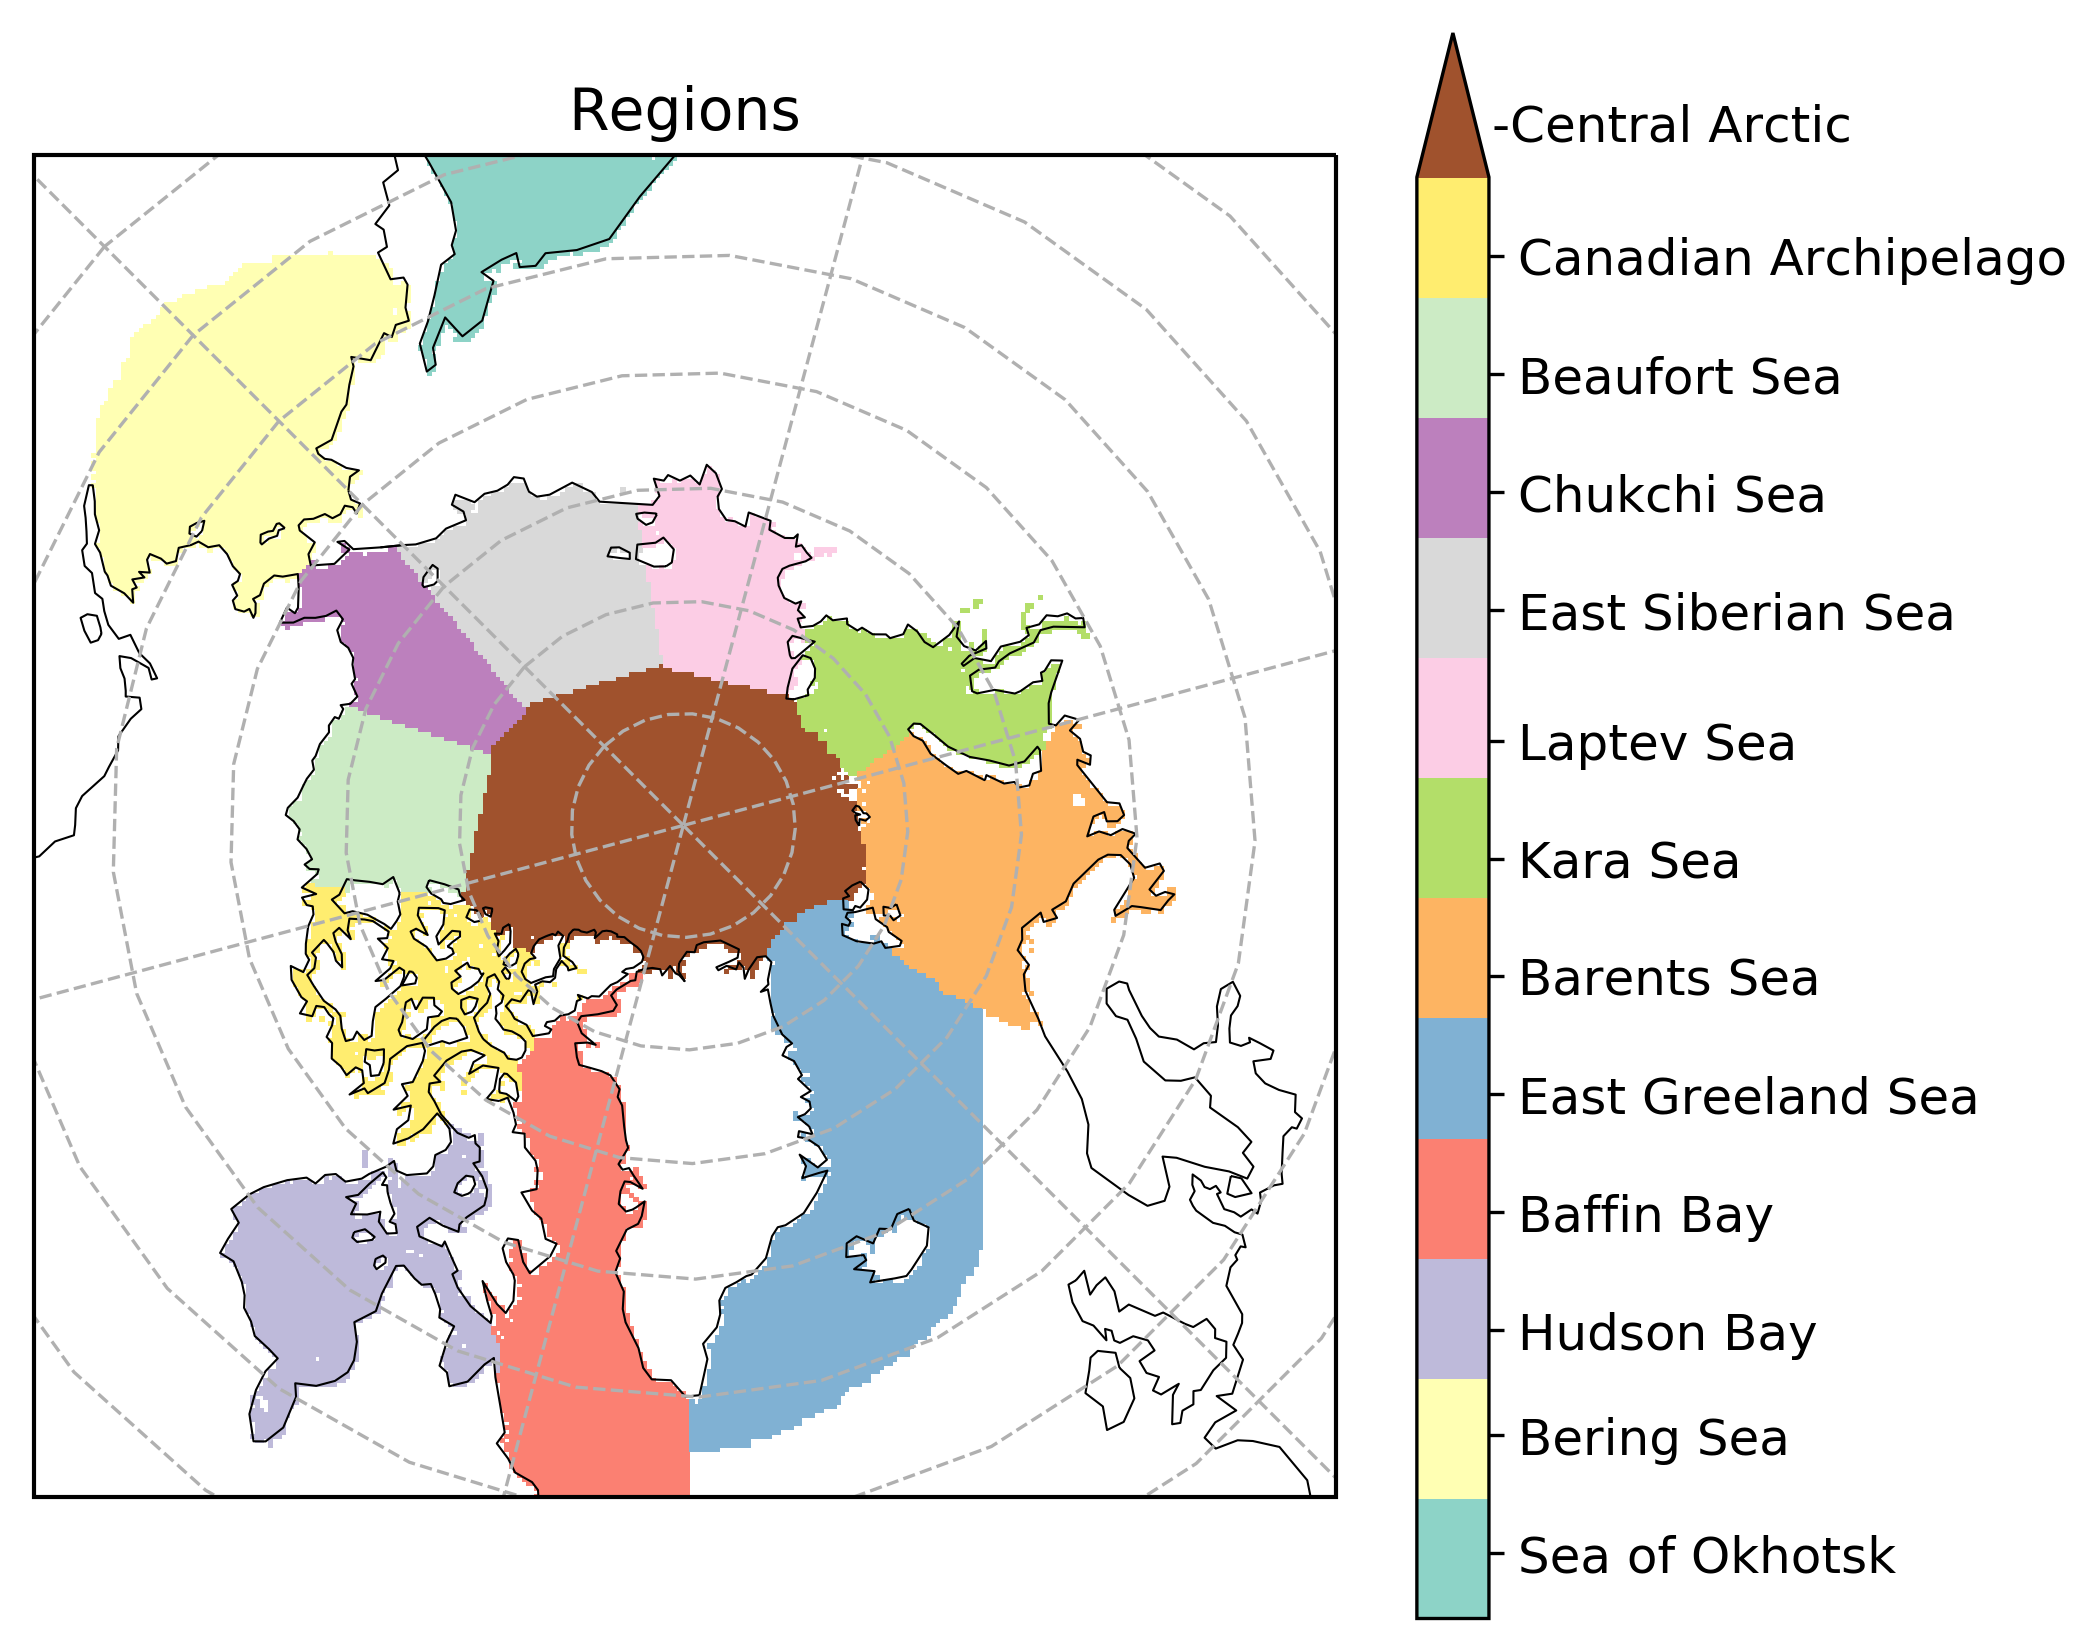

In [250]:
fig,ax = plt.subplots(1,1, figsize=(7, 7), subplot_kw = proj)

# #var1, lon1 = add_cyclic_point(VAR1, coord=LON)
# var1=VAR1
# lon1=LON
# new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
 
ax.set_extent([-150, 140, 55, 90], crs=ccrs.PlateCarree())
ax.gridlines(linestyle='--')

cmap = plt.cm.Set3
cmap.set_over('sienna')

cs = ax.pcolormesh(LON,LAT,VAR4,cmap=cmap, 
                 vmin=2,vmax=13,
                 transform=ccrs.PlateCarree())
ax.coastlines(resolution='110m', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor=(1,1,1))

cbar = fig.colorbar(cs, ax=ax,extend='max', extendfrac=0.1,
                    ticks=[2.5,3.4,4.2,5.1,6,6.9,7.8,8.7,9.7,10.6,11.5,12.4])
cbar.ax.set_yticklabels(['Sea of Okhotsk','Bering Sea','Hudson Bay','Baffin Bay',
                         'East Greeland Sea','Barents Sea','Kara Sea','Laptev Sea',
                         'East Siberian Sea','Chukchi Sea','Beaufort Sea','Canadian Archipelago',
                         'Central Arctic'],fontsize=12)

ax.text(1.12,1.01,'-Central Arctic',transform=ax.transAxes,fontsize=12)
 
ax.set_title('Regions',fontsize=14)
# plt.tight_layout()

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Regions.png'
plt.savefig(savedir+savename)

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(6, 5), subplot_kw = proj)

# #var1, lon1 = add_cyclic_point(VAR1, coord=LON)
# var1=VAR1
# lon1=LON
# new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
 
ax.set_extent([-150, 140, 55, 90], crs=ccrs.PlateCarree())
ax.gridlines(linestyle='--')

cs = ax.pcolormesh(LON,LAT,VAR1,cmap=plt.cm.tab20c, 
                   vmin=1,vmax=15,
                   transform=ccrs.PlateCarree())
ax.coastlines(resolution='110m', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor=(1,1,1))

plt.colorbar(cs, ax=ax,extend="neither")
ax.set_title('Regions')

In [72]:
for i in range(len(nsidc_regions.region_names)):
    print(str(i)+ ' ' + str(nsidc_regions.region_names[i].values)[2:-3])

0 Ice-free Oceans
1 Sea of Okhotsk 
2 Bering         
3 Hudson Bay     
4 St John        
5 Baffin Bay     
6 East Greeland S
7 Barents Sea    
8 Kara Sea       
9 Laptev Sea     
10 East Siberian S
11 Chukchi Sea    
12 Beaufort Sea   
13 Canadian Island
14 Central Arctic 
15 null           
16 null           
17 null           
18 null           
19 land           
20 land outline   


In [9]:
nsidc_regions.rename(name_dict={'nx':'nj','ny':'ni'})
nsidc_regions

<xarray.Dataset>
Dimensions:       (nregions: 21, nx: 304, ny: 448)
Dimensions without coordinates: nregions, nx, ny
Data variables:
    mask          (nx, ny) int32 ...
    lat           (nx, ny) float32 ...
    lon           (nx, ny) float32 ...
    area          (nx, ny) float32 ...
    region_names  (nregions) |S17 ...

In [10]:
nsidcthearea=np.zeros(21)
for nreg in nsidc_regions.nregions.values:
    nsidcthearea[nreg] = nsidc_regions.area.where(nsidc_regions.mask==nreg).sum(dim=('nx','ny')).values
nsidcthearea # in km x km

array([  335798.75  , 14853001.    ,  2207759.75  ,  2231437.25  ,
        1233463.625 ,   691208.5625,  2765305.    ,  2933018.    ,
        1674568.875 ,   918608.125 ,   872414.25  ,  1304342.75  ,
         830271.3125,   940219.375 ,   761228.25  ,  3224682.    ,
              0.    ,        0.    ,        0.    ,        0.    ,
       34965216.    ])

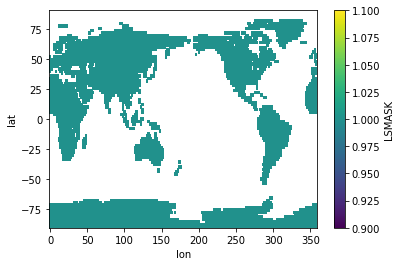

In [11]:
land = xr.open_dataset('/home/disk/p/mkb22/Documents/si_analysis_kb/regridding/LandSeaMask_2x2.nc')
land_mask = xr.where(land.LSMASK == 1.0, np.nan, 1)

land.LSMASK.where(land.LSMASK == 1.0).plot()

In [12]:
landfrac = xr.open_dataset(('/home/disk/p/mkb22/Documents/si_analysis_kb/regridding/'+
                            'regridded_data/sftlf_giss_2x2_2.nc'))
land_present = xr.where(landfrac>40,np.nan,1)

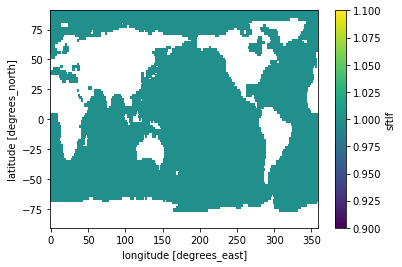

In [13]:
land_present.sftlf.plot()

In [17]:
landfrac.sftlf

<xarray.DataArray 'sftlf' (lat: 91, lon: 180)>
array([[100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       [100., 100., 100., ..., 100., 100., 100.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes:
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...
    history:           2011-10-31T17:26:31Z altered by CMOR: replaced missing...
    cell_measures:     area: areacella
    original_name:     sftlf
    units:             %
    long_name:         Land Area Fraction
    standard_name:     land_area_fraction

In [22]:
models = ['CCSM4','MPI']
method = 'nearest_s2d'  #'conservative' #     #method = 'nearest_d2s'  # this was bad do not use

dirf = '/home/disk/p/mkb22/Documents/si_analysis_kb/regridding/'
file = 'cellareaa_2x2.nc'
ds_model = xr.open_dataset(dirf+file)

regridder = xe.Regridder(nsidc_grid, ds_model, method, periodic=False, reuse_weights=False)
model_regions = regridder(nsidc_regions.mask)

model_regions = xr.where(land.LSMASK == 1.0, np.nan, model_regions)
model_regions = xr.where(model_regions_new.lat <40, np.nan, model_regions)

#model_regions = xr.where(land.LSMASK == 1.0, np.nan, model_regions)

# compute the maximum possible areas of each region so we can check later how much they vary
thearea=np.zeros(21)
horizdims = ds_model.cell_area.dims
for nreg in nsidc_regions.nregions.values:
    areacello_byreg=ds_model.cell_area.where(model_regions==nreg)
    thearea[nreg] = areacello_byreg.sum(dim=horizdims).values

# shove stuff into the xarray
ds_model['region_names']=nsidc_regions.region_names
ds_model['region_mask'] =model_regions
ds_model['region_area'] =xr.DataArray(thearea*1e-6, dims='nregions') # in km x km
ds_model['region_area_relative2NSIDC'] =xr.DataArray(thearea*1e-6/nsidcthearea, dims='nregions')

outfile='regionmask_surfaceareacell_2x2_grid.nc'
ds_model.to_netcdf(outfile)

Overwrite existing file: nearest_s2d_304x448_91x180.nc 
 You can set reuse_weights=True to save computing time.


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test_test/lib/python3.6/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


NameError: name 'model_regions_new' is not defined

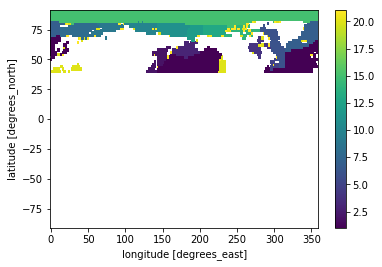

In [343]:
model_regions_new = xr.where(landfrac.sftlf>70, np.nan, model_regions)
model_regions_new = xr.where(model_regions_new.lat <40, np.nan, model_regions_new)
model_regions_new.plot()

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


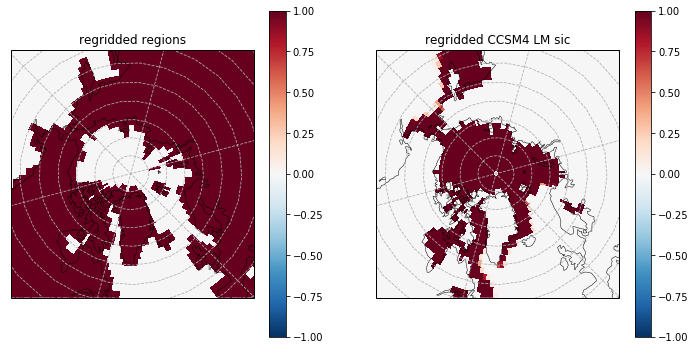

In [345]:
fig,ax = plt.subplots(1,2, figsize=(12, 6), subplot_kw = proj)
ax = ax.flatten()

sub_arctic_plot(fig,ax[0],landfrac.sftlf.values,
                model_regions_new.lat.values,model_regions_new.lon.values,
                'regridded regions',
                1, colorbar=True, extent=True)

sub_arctic_plot(fig,ax[1],sic_prior_regrid[0,:,:],
                lat_sic_new[:,0],lon_sic_new[0,:],
                'regridded CCSM4 LM sic',
                1, colorbar=True, extent=True)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

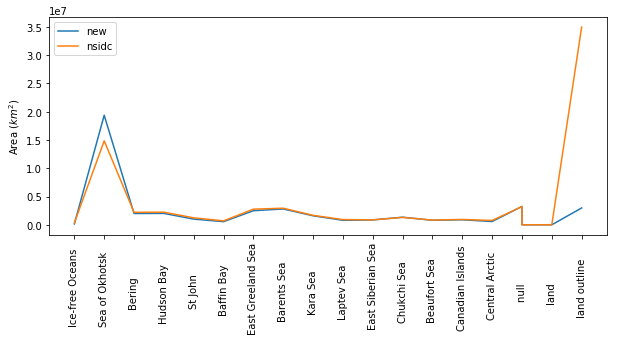

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(ds_model.region_names,thearea/(np.power(10,6)), label='new')
plt.plot(ds_model.region_names,nsidcthearea, label='nsidc')
plt.ylabel('Area ($km^{2}$)')
plt.legend()
plt.xticks(rotation=90)

In [163]:
import pickle

output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_ccsm4 = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'

sample_data = pickle.load(open(output_dir_ccsm4+output_file_ccsm4,'rb'))

In [198]:
if sample_data['sic_lalo'].max() > 1.0: 
    sample_data['sic_lalo'] = sample_data['sic_lalo']/100.0

sic_sample = xr.DataArray(sample_data['sic_lalo'], dims=["time","lat","lon"],
                          coords={"time": np.array(sample_data['recon_years']),
                                  "lat": areacello_byreg.lat.values, 
                                  "lon":areacello_byreg.lon.values})

sie = np.where(sample_data['sic_lalo']>0.15,1.0,0.0)

sie_sample = xr.DataArray(sie, dims=["time","lat","lon"],
                          coords={"time": np.array(sample_data['recon_years']),
                                  "lat": areacello_byreg.lat.values, 
                                  "lon":areacello_byreg.lon.values})

In [202]:
regional_sic = {}
regional_sie = {}
regional_tot_area = {}

horizdims = ds_model.cell_area.dims
for nreg in nsidc_regions.nregions.values[1:16]:
    areacello_byreg=ds_model.cell_area.where(model_regions==nreg)/(1e6)
    regional_sic[str(ds_model.region_names[nreg].values)[2:-3]] = (areacello_byreg*sic_sample).sum(dim=['lat','lon']).values
    regional_sie[str(ds_model.region_names[nreg].values)[2:-3]] = (areacello_byreg*sie_sample).sum(dim=['lat','lon']).values
    regional_tot_area[str(ds_model.region_names[nreg].values)[2:-3]] = areacello_byreg.sum(dim=['lat','lon']).values

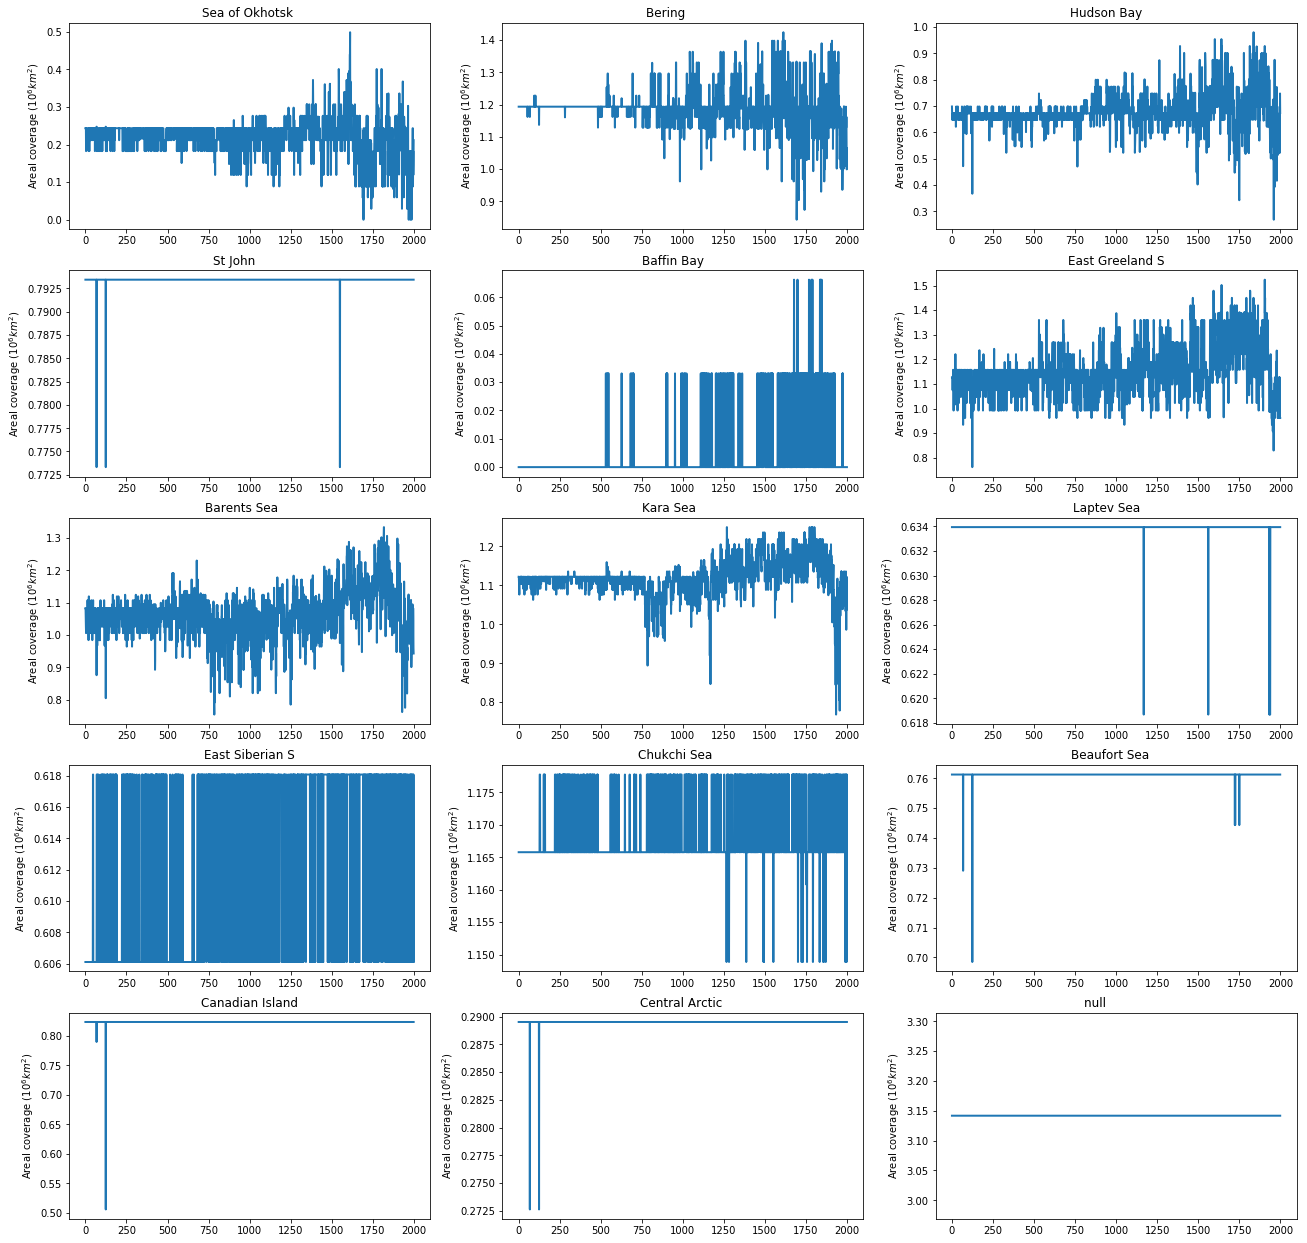

In [205]:
fig,ax = plt.subplots(nrows=5,ncols=3)
fig.set_size_inches(22,22)
ax = ax.flatten()

for ireg,reg in enumerate(regional_sic.keys()):
    ax[ireg].plot(np.array(sample_data['recon_years']),regional_sie[reg]/(1e6),linewidth=2)
    ax[ireg].set_title(reg)
    ax[ireg].set_ylabel('Areal coverage ($10^6 km^2$)')
#    ax[ireg].axhline(regional_tot_area[reg]/(1e6),linestyle='--')

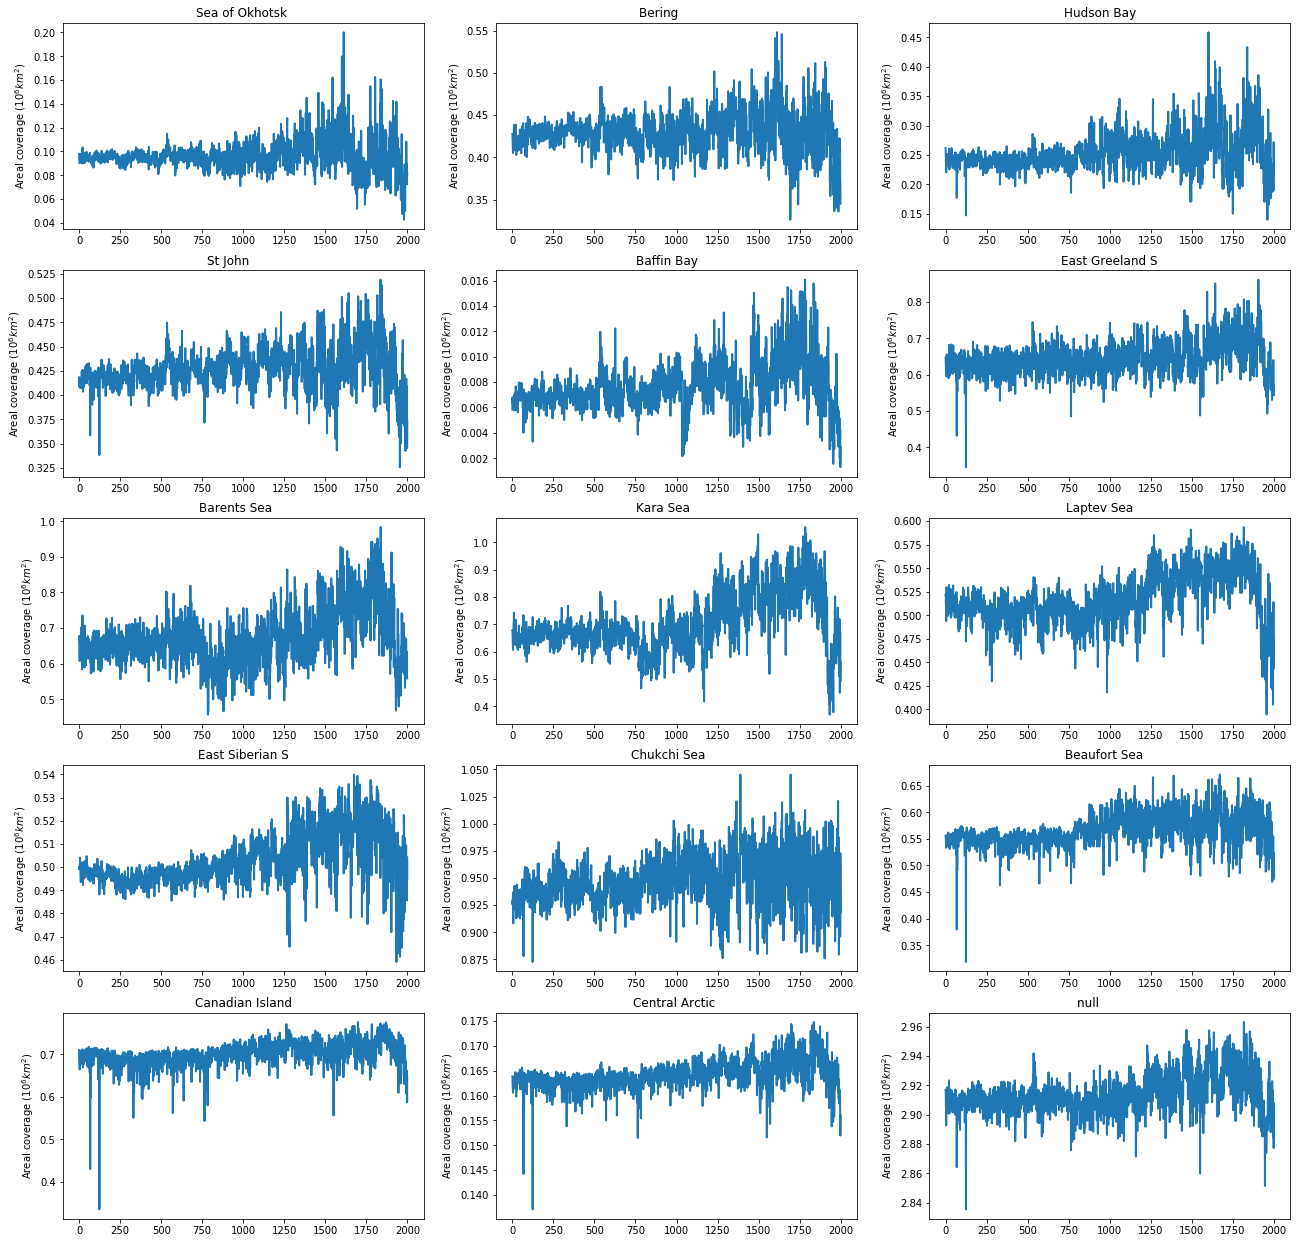

In [180]:
fig,ax = plt.subplots(nrows=5,ncols=3)
fig.set_size_inches(22,22)
ax = ax.flatten()

for ireg,reg in enumerate(regional_sic.keys()):
    ax[ireg].plot(np.array(sample_data['recon_years']),regional_sic[reg]/(1e6),linewidth=2)
    ax[ireg].set_title(reg)
    ax[ireg].set_ylabel('Areal coverage ($10^6 km^2$)')
    

### Check regridding from LMR of prior data: 

In [245]:
sys.path.insert(1,'/home/disk/kalman2/mkb22/LMR_lite/')
import LMR_lite_utils as LMRlite
import LMR_utils as lmr 
import LMR_config

In [207]:
# inflate the sea ice variable here (can inflate whole state here too)
inflate = 1.0
inf_name = '1'

#prior_name = 'mpi'
prior_name = 'ccsm4'

pp_err = 0.1
#pp_err = False
serr = '0_1'
#serr = 'pages2kv2'

cfile = '/home/disk/kalman2/mkb22/LMR_lite/configs/config_ccsm4_brennan2020.yml'

proxies = 'pseudo'

savedir = ('/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/')

print('loading configuration...')
cfg = LMRlite.load_config_simple(cfile)

recon_start = str(cfg.core.recon_period[0])
recon_end = str(cfg.core.recon_period[1])
loc_list = [cfg.core.loc_rad]
    
iter_range = cfg.wrapper.iter_range
MCiters = range(iter_range[0],iter_range[1]+1)

proxy_ind = np.zeros((iter_range[1]+1,405))
prior_ind = np.zeros((iter_range[1]+1,200))

loading configuration...
Checking configuration ... 
OK!


In [208]:
# LOAD PRIOR ENSEMBLE: 
print('loading prior')
X, Xb_one = LMRlite.load_prior(cfg)
Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

# Save lat/lon of prior for later reloading and regridding of truth data
prior_lat_full = X.prior_dict['tas_sfc_Amon']['lat']
prior_lon_full = X.prior_dict['tas_sfc_Amon']['lon']

prior_sic_lat_full = X.prior_dict['sic_sfc_OImon']['lat']
prior_sic_lon_full = X.prior_dict['sic_sfc_OImon']['lon']

# check if config is set to regrid the prior
if cfg.prior.regrid_method:
    print('regridding prior...')
    # this function over-writes X, even if return is given a different name
    [X_regrid,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=True)
else:
    X_regrid.trunc_state_info = X.full_state_info

# --------------------------------------------------
# make a grid object for the prior
grid = LMRlite.Grid(X_regrid)

# locate position of variables in Xb_one_new: 
tas_pos = X_regrid.trunc_state_info['tas_sfc_Amon']['pos']
sic_pos = X_regrid.trunc_state_info['sic_sfc_OImon']['pos']

loading prior
Reading file:  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence<<: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
Reading file:  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/sic_sfc_OImon_CCSM4_past1000_085001-185012.nc
(12012, 180, 360)
indlat= 0  indlon= 1
Full field provided as the prior
sic : Global(monthly): mean= 13.445376  , std-dev= 32.317898
Averaging over month sequence<<: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
sic : Global(time-averaged): mean= 13.445537533002385  , std-dev= 31.06984518565762
 
State vector information:
Nx = 120096
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spac

In [229]:
original_ccsm4_sic = X.prior_dict['sic_sfc_OImon']['value']
original_ccsm4_lat = X.prior_dict['sic_sfc_OImon']['lat']
original_ccsm4_lon = X.prior_dict['sic_sfc_OImon']['lon']

In [258]:
# Load full prior for sic and regrid: --------------------
prior_sic_orig = X.prior_dict['sic_sfc_OImon']['value']

prior_sic_regrid_prep = np.transpose(np.reshape(prior_sic_orig,
                                                (prior_sic_orig.shape[0],
                                                 prior_sic_orig.shape[1]*prior_sic_orig.shape[2])))

# Regrid full sic prior for proxy selection: 
[prior_sic_regrid,lat_sic_new,lon_sic_new] = lmr.regrid_esmpy(cfg.prior.esmpy_grid_def['nlat'],
                                                              cfg.prior.esmpy_grid_def['nlon'],
                                                              nyears,
                                                              prior_sic_regrid_prep,
                                                              prior_sic_lat_full,
                                                              prior_sic_lon_full,
                                                              180,360,
                                                              method=cfg.prior.esmpy_interp_method)

sic_prior_regrid = np.reshape(np.transpose(prior_sic_regrid),
                              (nyears,
                               cfg.prior.esmpy_grid_def['nlat'],
                               cfg.prior.esmpy_grid_def['nlon'],))

In [263]:
sic_prior_regrid, lat_sic_new

((1001, 91, 180),
 array([[-89.01098901, -89.01098901, -89.01098901, ..., -89.01098901,
         -89.01098901, -89.01098901],
        [-87.03296703, -87.03296703, -87.03296703, ..., -87.03296703,
         -87.03296703, -87.03296703],
        [-85.05494505, -85.05494505, -85.05494505, ..., -85.05494505,
         -85.05494505, -85.05494505],
        ...,
        [ 85.05494505,  85.05494505,  85.05494505, ...,  85.05494505,
          85.05494505,  85.05494505],
        [ 87.03296703,  87.03296703,  87.03296703, ...,  87.03296703,
          87.03296703,  87.03296703],
        [ 89.01098901,  89.01098901,  89.01098901, ...,  89.01098901,
          89.01098901,  89.01098901]]))

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


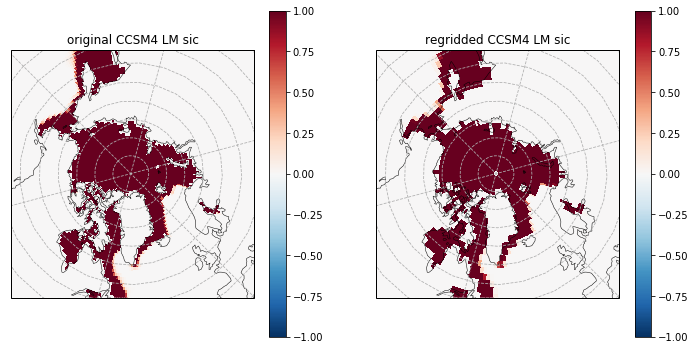

In [265]:
fig,ax = plt.subplots(1,2, figsize=(12, 6), subplot_kw = proj)
ax = ax.flatten()

sub_arctic_plot(fig,ax[0],original_ccsm4_sic[0,:,:],
                original_ccsm4_lat[:,0],original_ccsm4_lon[0,:],
                'original CCSM4 LM sic',
                1, colorbar=True, extent=True)

sub_arctic_plot(fig,ax[1],sic_prior_regrid[0,:,:],
                lat_sic_new[:,0],lon_sic_new[0,:],
                'regridded CCSM4 LM sic',
                1, colorbar=True, extent=True)

In [284]:
sic_orig_da = xr.DataArray(original_ccsm4_sic, 
                           coords={'time': np.arange(850,1851,1),
                                   'lat': original_ccsm4_lat[:,0],
                                   'lon': original_ccsm4_lon[0,:]},
                           dims={'time','lat','lon'})

sic_regrid_da = xr.DataArray(sic_prior_regrid, 
                             coords={'time': np.arange(850,1851,1),
                                     'lat': lat_sic_new[:,0],
                                     'lon': lon_sic_new[0,:]},
                             dims={'time','lat','lon'})

sic_ccsm4_ds = xr.Dataset({'sic_regridded_ccsm4_lm':sic_regrid_da,
                           'sic_original_ccsm4_lm': sic_orig_da})

In [285]:
# save_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
# savename = 'sic_CCSM4_past1000_850_1850_original_and_regridded.nc'
# sic_ccsm4_ds.to_netcdf(save_dir+savename)

In [347]:
ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
ccsm4_file = 'sic_OImon_CCSM4_past1000_r1i1p1_085001-185012.nc'

ccsm4_og_og = xr.open_dataset(ccsm4_dir+ccsm4_file)

In [353]:
ccsm4_og_og.sic_anmn = ccsm4_og_og.sic.groupby('time.year').mean('time')

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


AttributeError: cannot set attribute 'sic_anmn' on a 'Dataset' object. Use __setitem__ style assignment (e.g., `ds['name'] = ...`) instead to assign variables.

In [ ]:
prior_sic_orig = X.prior_dict['sic_sfc_OImon']['value']

prior_sic_regrid_prep = np.transpose(np.reshape(prior_sic_orig,
                                                (prior_sic_orig.shape[0],
                                                 prior_sic_orig.shape[1]*prior_sic_orig.shape[2])))

# Regrid full sic prior for proxy selection: 
[prior_sic_regrid,lat_sic_new,lon_sic_new] = lmr.regrid_esmpy(cfg.prior.esmpy_grid_def['nlat'],
                                                              cfg.prior.esmpy_grid_def['nlon'],
                                                              nyears,
                                                              prior_sic_regrid_prep,
                                                              prior_sic_lat_full,
                                                              prior_sic_lon_full,
                                                              180,360,
                                                              method=cfg.prior.esmpy_interp_method)

sic_prior_regrid = np.reshape(np.transpose(prior_sic_regrid),
                              (nyears,
                               cfg.prior.esmpy_grid_def['nlat'],
                               cfg.prior.esmpy_grid_def['nlon'],))

In [112]:
sic_sample = xr.DataArray(sample_data['sic_lalo'], dims=["time","lat","lon"],
                          coords={"time": np.arange(1400,1850),
                                  "lat": areacello_byreg.lat.values, 
                                  "lon":areacello_byreg.lon.values})

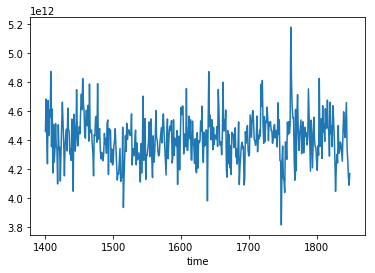

In [120]:
(areacello_byreg*sic_sample).sum(dim=['lat','lon']).plot()

In [156]:
grid_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/regridding/sftlf_2x2.nc'
grid = xr.open_dataset(grid_dir)

(91, 180)

In [160]:
t = np.arange(1400,1850,1)
# lat = (np.ones((91,180)).T*grid.lat.values).T
# lon = (np.ones((91,180))*grid.lon.values)
lat = grid.lat.values
lon = grid.lon.values

sic = xr.DataArray(sample_data['sic_lalo'], coords=[t, lat, lon], dims=["time","lat","lon"])

sic = sic.to_dataset(name="sic")

sic.to_netcdf('/home/disk/p/mkb22/Documents/si_analysis_kb/regridding/sic_sample_dataset_2x2.nc')

In [161]:
land = xr.open_dataset('/home/disk/p/mkb22/Documents/si_analysis_kb/regridding/LandSeaMask_2x2.nc')

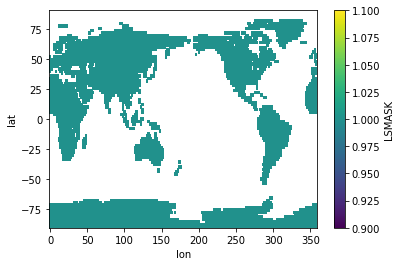

In [168]:
land.LSMASK.where(land.LSMASK == 1.0).plot()

In [175]:
mask_dir = '/home/disk/eos8/ed/Greg_proposal/'
mask_file = 'sio_mask.nc'

mask_data = xr.open_dataset(mask_dir+mask_file)

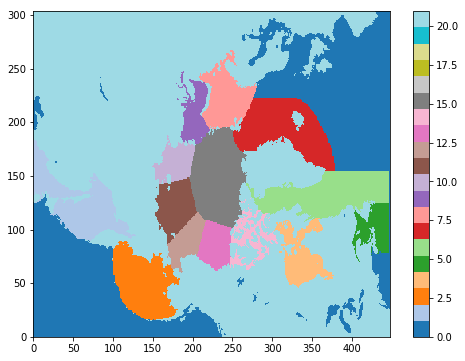

In [176]:
plt.figure(figsize=(8,6))
plt.pcolormesh(mask_data.mask,cmap='tab20')
plt.colorbar()

In [177]:
sat_mask = mask_data.mask.values
sat_area = mask_data.area.values

sat_barents_mask = np.where(np.isclose(sat_mask,8,atol=10e-4),1,0)
sat_barents_area = np.multiply(sat_barents_mask,sat_area)
# barents_mask = barents_mask[np.where(barents_mask>7)]

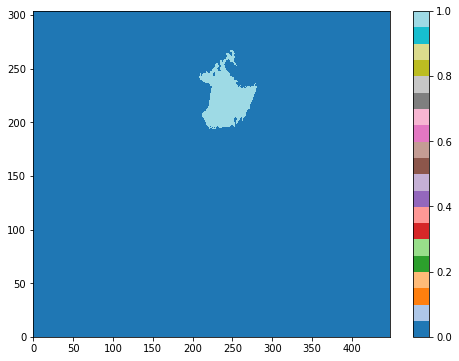

In [178]:
plt.figure(figsize=(8,6))
plt.pcolormesh(sat_barents_mask,cmap='tab20')
plt.colorbar()

### Load NSIDC regions on a 2 x 2 grid: 

In [62]:
mask_regrid_file = 'nsidc_arctic_regional_mask_91_180.nc'
mask_regrid_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/Observations/'

mask_data_regrid = xr.open_dataset(mask_regrid_dir+mask_regrid_file)

In [63]:
regrid_mask = mask_data_regrid.mask.values
regrid_area = mask_data_regrid.area.values

barents_mask = np.where(np.isclose(regrid_mask,8,atol=10e-4),1,0)
barents_area = np.multiply(barents_mask,regrid_area)
# barents_mask = barents_mask[np.where(barents_mask>7)]

In [71]:
sat_barents_area.sum(), barents_area.sum(), 

(1674568.9270629883,
 73495.5336751492,
 array([[382.659, 383.765, 384.872, ..., 406.945, 405.846, 404.746],
        [383.385, 384.494, 385.604, ..., 407.74 , 406.638, 405.536],
        [384.108, 385.221, 386.333, ..., 408.533, 407.428, 406.322],
        ...,
        [386.973, 388.099, 389.224, ..., 411.675, 410.557, 409.439],
        [386.261, 387.383, 388.505, ..., 410.894, 409.779, 408.664],
        [385.546, 386.665, 387.784, ..., 410.11 , 408.999, 407.886]],
       dtype=float32))

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


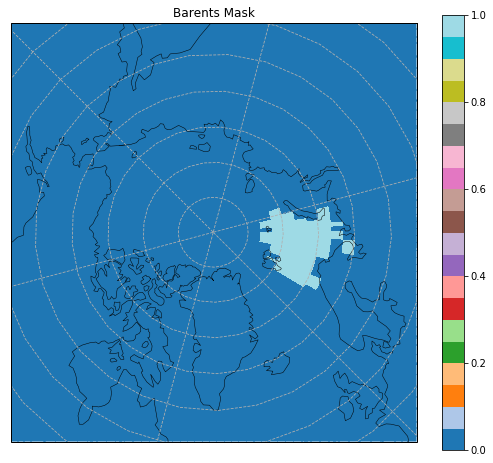

In [67]:
plt.figure(figsize=(20,8))

sic_U1, sic_lon1 = add_cyclic_point(barents_mask, coord=mask_data_regrid.longitude.values)
new_lon2d_u, new_lat2d_u = np.meshgrid(sic_lon1, mask_data_regrid.latitude.values)

ax_u = plt.subplot(1, 2, 1, projection=ccrs.Stereographic(central_latitude=90,
                                                central_longitude=-45,
                                                true_scale_latitude=0.1))

ax_u.set_extent([-150, 140, 55, 90], crs=ccrs.PlateCarree())
ax_u.gridlines(linestyle='--')
ax_u.add_feature(cfeature.LAND, facecolor=(1, 1, 1))

cs_u = ax_u.pcolormesh(new_lon2d_u, new_lat2d_u, sic_U1,
                       cmap='tab20',
                       transform=ccrs.PlateCarree())

ax_u.coastlines(resolution='110m', linewidth=0.5)
plt.title('Barents Mask')
plt.colorbar(cs_u)


#ax_u.plot(75,180, marker="o", markersize=8, alpha=0.6, c="orange")
# ax_u.plot(32, 75, 'bo', markersize=7, transform=ccrs.PlateCarree())

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


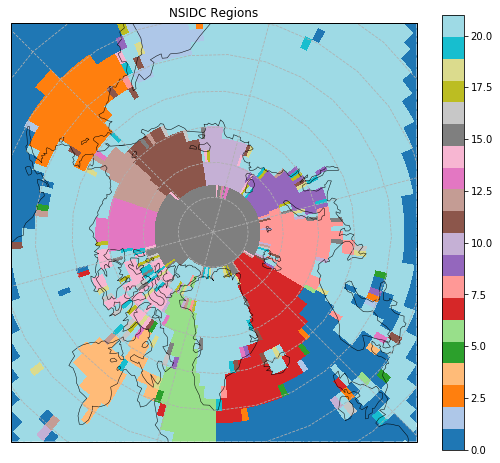

In [66]:
plt.figure(figsize=(20,8))

sic_U1, sic_lon1 = add_cyclic_point(mask_data_regrid.mask.values, coord=mask_data_regrid.longitude.values)
new_lon2d_u, new_lat2d_u = np.meshgrid(sic_lon1, mask_data_regrid.latitude.values)

ax_u = plt.subplot(1, 2, 1, projection=ccrs.Stereographic(central_latitude=90,
                                                central_longitude=-45,
                                                true_scale_latitude=0.1))

ax_u.set_extent([-150, 140, 55, 90], crs=ccrs.PlateCarree())
ax_u.gridlines(linestyle='--')
ax_u.add_feature(cfeature.LAND, facecolor=(1, 1, 1))

cs_u = ax_u.pcolormesh(new_lon2d_u, new_lat2d_u, sic_U1,
                       cmap='tab20',
                       transform=ccrs.PlateCarree())

ax_u.coastlines(resolution='110m', linewidth=0.5)
plt.title('NSIDC Regions')
plt.colorbar(cs_u)
